# Capítulo 2

In [2]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [ ]:
%%R
library(rethinking) # McElreath lib
globe.qa <- quap( # quadratic approximation
    alist(
        W ~ dbinom( W+L ,p) , # binomial likelihood
        p ~ dunif(0,1) # uniform prior
    ),
    data=list(W=6,L=3) 
)

# display summary of quadratic approximation
precis( globe.qa )

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


En python no conozco implementado la aproximación cuadrática. Por lo que se integra así:

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

W, L = 6, 3 # Observed data definition.

# 1. log posterior
def logpost(p):
    p = p[0] # gymnastics because we pass an array([0.5]) for the MAP, relevant on interval.
    if p <= 0 or p >= 1: # we set the boundries.
        return -np.inf # if unbounded return -inf.
    return W*np.log(p) + L*np.log(1 - p) # we sum ln(p)

# 2. MAP estimate | MAP is the maximum a posteriori. 
res = minimize(
    lambda x: -logpost(x),
    x0=np.array([0.5]),
    method="L-BFGS-B",
    bounds=[(1e-6, 1 - 1e-6)] # small enough bounds, just numerical safeguards.
)

map_est = res.x[0] # this is the MAP, we now calculate intervals.

#  3. Numerical Hessian
eps = 1e-5 # epsilon
# it is the finite-difference step 
# used to approximate the second derivative

# fpp is "f" prime prime or f''
# This is a scalar because the parameter space is 1-D.
# The Hessian reduces to a 1×1 matrix whose only entry is f''(p).
fpp = ( 
    -logpost([map_est + eps]) # lo
    - 2*-logpost([map_est])   # MAP
    -logpost([map_est - eps]) # hi
) / eps**2

# Hessian = f'' ; covariance = 1/H
var = 1.0 / fpp
sd = np.sqrt(var)

# 4. HDI from Gaussian approx
# Because we're doing a quad approximation
# We asume a normal distribution
# Loc=mu, scale=sd.
lo = norm.ppf(0.055, loc=map_est, scale=sd)
hi = norm.ppf(0.945, loc=map_est, scale=sd)

# This is just done to round the values
map_est, sd, lo, hi = np.array([map_est, sd, lo, hi]).round(2)

print("MAP:", map_est)
print("SD:", sd)
print("89% HDI:", lo, hi)


MAP: 0.67
SD: 0.16
89% HDI: 0.42 0.92


PyMc can be used to calculate the quad map but not directly the confidence interval nor the standard deviation.

In [59]:
import pymc as pm

with pm.Model() as glob_model:
    p = pm.Uniform('p', 0, 1)
    lk = pm.Binomial('likelihood', n=W+L, p=p, observed=W)
    mp = pm.find_MAP()

print('Map approximation:', mp['p'])

Output()

Map approximation: 0.6666666671652423


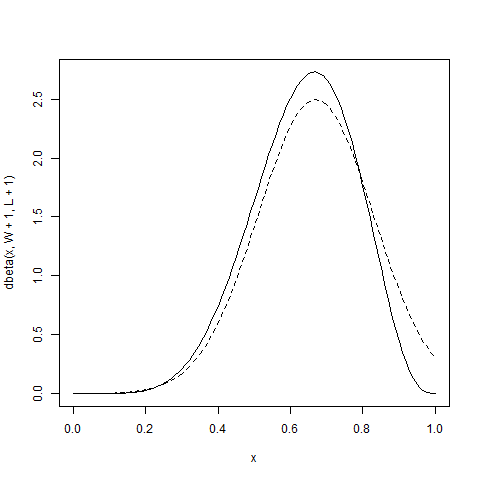

In [61]:
%%R
W <- 6
L <- 3
curve( dbeta( x , W+1 , L+1 ) , from=0 , to=1 )
# quadratic approximation
curve( dnorm( x , 0.67 , 0.16 ) , lty=2 , add=TRUE )

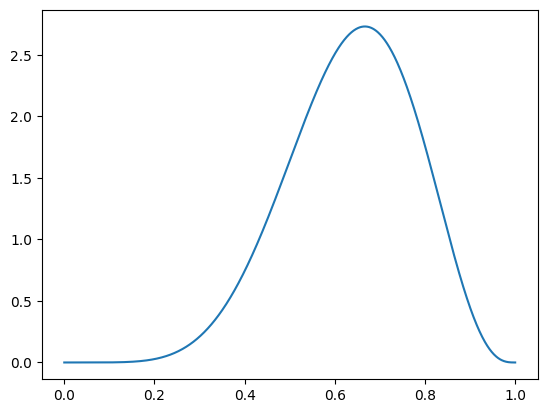

In [62]:
import scipy.stats as stats
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, W+1, L+1)
plt.plot(x, y)

This is the beta posterior from observed data updating from a uniform distribution.

Full MCMC model:

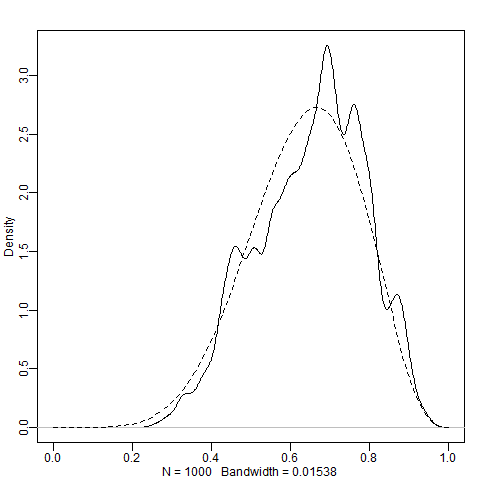

In [ ]:
%%R
n_samples <- 1000
p <- rep( NA , n_samples )
p[1] <- 0.5
W <- 6
L <- 3
for ( i in 2:n_samples ) {
p_new <- rnorm( 1 , p[i-1] , 0.1 )
    if ( p_new < 0 ) p_new <- abs( p_new )
    if ( p_new > 1 ) p_new <- 2 - p_new
    q0 <- dbinom( W , W+L , p[i-1] )
    q1 <- dbinom( W , W+L , p_new )
    p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
}
dens( p , xlim=c(0,1) )
curve( dbeta( x , W+1 , L+1 ) , lty=2 , add=TRUE )

    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.636  0.14   0.381    0.888      0.004    0.002    1227.0    1276.0    1.0


<Axes: title={'center': 'p'}>

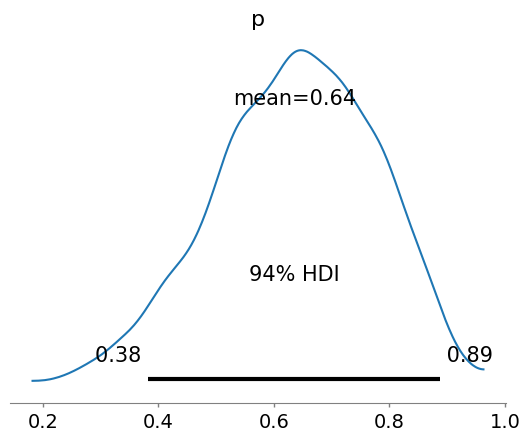

In [69]:
import arviz as az
with pm.Model() as glob_model:
    p = pm.Beta('p', 1,1)
    lk = pm.Binomial('lk', p=p, n=W+L, observed=W)
    idata = pm.sample(nuts_sampler='blackjax', progressbar=None)

print(az.summary(idata))
az.plot_posterior(idata)